## Stimulating a neuron with synaptic current 

In [241]:
# Author #
#########
# Rahul Nauni
# ppxrn1@nottingham.ac.uk
# This code includes solution for Q2 and Q3 of Assignment.
# References used: 
# https://github.com/NeuromatchAcademy/course-content/blob/main/tutorials/W2D3_BiologicalNeuronModels/W2D3_Tutorial1.ipynb
# https://compneuro.neuromatch.io/tutorials/W2D3_BiologicalNeuronModels/student/W2D3_Tutorial1.html

In [145]:
# Importing dependencies
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

The dynamics of LIF neuron model under synaptic input can be explained by

\begin{equation}
    C_{\rm m} \frac{\rm dv}{\rm dt} = -g_{\rm L}(V - E_{\rm L}) + I_{\rm syn(t)} + I_{\rm ext} \tag{1}
\end{equation}

where $C_{\rm m}$ is the membrane capacitance, $g_{\rm L}$ is the leak potential, $I_{\rm ext}$ is an external current injected in the neuron, $I_{\rm syn(t)}$ is the synaptic current.

Assuming neuron has LIF model, we can estimate $C_{\rm m}$ as:

\begin{equation}
    C_{\rm m} = \tau_{\rm m} / R_{\rm m} \tag{2}
\end{equation}


In [146]:
# Define the model parameters
def default_params(**kwargs):
    params = {}

    # Define neuron parameters
    params['tau_m'] = 50.0 # Membrane time constant
    params['g_L'] = 1e-6  # Leak resistance (in ohms)
    params['E_L'] = 0.0  # Resting potential (in mV)
    params['V_th'] = 20.0  # Threshold voltage (in mV)
    params['V_reset'] = 0.0  # Reset voltage (in mV)
    params['V_init'] = 0.0   # initial potential [mV]
    params['t_ref'] = 2.0  # Refractory period (in ms)

    # Define the simulation parameters
    params['dt'] = 0.1  # Time step (in ms)
    params['T'] = 1000.0  # Simulation duration (in ms)

    params['range_t'] = np.arange(0, params['T'], params['dt'])  # Vector of discretized time points [ms]

    # external parameters if any 
    for k in kwargs:
        params[k] = kwargs[k]

    return params

In [147]:
def generate_poisson_spikes(params, rate, user_seed=False):
    """
    Generate poisson spike trains

    Args:
    params      :   Parameters dictionary
    rate        :   Poisson noise amplitude (Hz)
    n           :   Number of Poisson spike trains
    user_seed   :   Random seed. int or boolean
    """
     # get simulation parameters
    dt, range_t = params['dt'], params['range_t'] 
    Lt = range_t.size
    
    # set random seed
    if user_seed:
        np.random.seed(seed=user_seed)
    else:
        np.random.seed()
    
    # generate poisson spike trains
    I_pos = np.random.poisson(lam=rate * (dt/1000.), size=Lt) 
    
    return I_pos

In [148]:
# Synaptic current waveform
def synaptic_current(I0, tau_syn, t):
    return I0 * np.sum(np.exp(-t/tau_syn))

In [149]:
def run_synaptic_LIF(params, I_ext):
    """
    Calculate coefficient of variation of interspike intervals as a function of stimulus rate

    Args:
    params      :   Parameters dictionary
    rate_range  :   Range of stimulus rates (Hz)
    num_trials  :   Number of trials for each rate

    Returns:
    cv_list     :   List of coefficients of variation for each rate
    """
    # Set parameters
    V_th, V_reset = params['V_th'], params['V_reset']
    tau_m, g_L = params['tau_m'], params['g_L']
    I0 = params['I0']
    tau_syn = params['tau_syn']
    V_init, E_L = params['V_init'], params['E_L']
    dt, range_t = params['dt'], params['range_t']
    t_ref = params['t_ref']
    Lt = range_t.size
    
    # Initialize voltage and current
    v = np.zeros(Lt)
    v[0] = V_init
    I_ext = I_ext * np.ones(Lt)
    I_syn = np.zeros_like(I_ext)
    tr = 0.  # the count for refractory duration

    rec_spikes = [] # record spike times
    # Simulate LIF dyanmics
    for it in range(Lt - 1):
        
        # Compute synaptic current
        if len(rec_spikes) > 0:
            t = (it*dt - rec_spikes)
            I_syn[it+1] = synaptic_current(I_syn[it], tau_syn, t)
        else:
            I_syn[it+1] = I_syn[it] + I0

        if tr > 0:  # check if in refractory period
            v[it] = V_reset  # set voltage to reset
            tr = tr - 1 # reduce running counter of refractory period

        elif v[it] >= V_th:  # if voltage over threshold
            rec_spikes = np.append(rec_spikes, it*dt)  # record spike event
            v[it] = V_reset  # reset voltage
            tr = t_ref / dt  # set refractory time

        # calculate the increment of the membrane potential
        dv = (-(v[it] - E_L) + I_ext[it] / g_L + I_syn[it]) * (dt / tau_m)

        # Update the membrane potential
        v[it + 1] = v[it] + dv
        
        # Get spike times in ms
        rec_spikes = np.array(rec_spikes) * dt
    
    return rec_spikes

In [159]:
def plot_firing_rate_vs_input(params, rate_range):
    """
    Plots the firing rate as a function of the input current.

    Args:
    params          : parameter dictionary
    rate_range      : firing rate range of the Poisson process

    Returns:
    None (plots the results)
    """
    
    spk_counts = np.zeros(len(rate_range))

    for idx in range(len(rate_range)):
        I_pos = generate_poisson_spikes(params, rate=rate_range[idx], user_seed=2020)
        rec_spikes = run_synaptic_LIF(params, I_ext=I_pos)
        spk_counts[idx] = len(rec_spikes)

    # Plot the F-I curve i.e. Output firing rate as a function of input mean.
    plt.figure()
    plt.plot(rate_range, spk_counts, 'bo-', alpha=0.8, lw=2, dashes=(2, 2),
            label='Poisson input')
    plt.ylabel('Spike count')
    plt.xlabel('Average injected current (nA)')
    plt.legend(loc='best')
    plt.title('Firing Rate vs. Input Current')
    plt.savefig('Synaptic_Firing_rate(Hz)_vs_External_input_current(mA)_plot.pdf')
    plt.show()

    return spk_counts

In [222]:
# Default parameters
params = default_params(T=1000.)

# Add parameters
params['tau_syn'] = 5.  # [ms]
params['I0'] = 20.

# Generate poisson spike trains
rate_range = np.arange(1, 1000, 50) # poisson rate range (Hz)

Text(0, 0.5, '$I_{pos}$ (nA)')

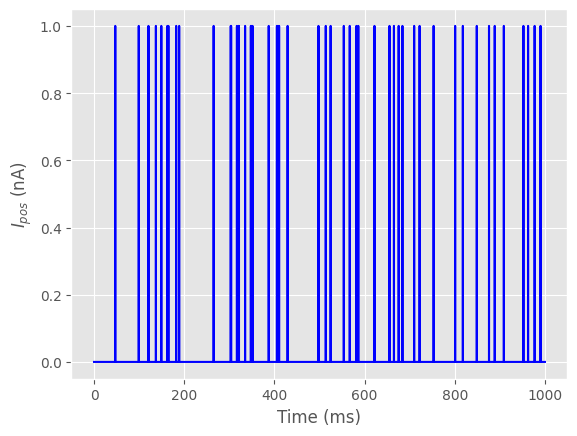

In [223]:
# Plot example input spikes
I_pos = generate_poisson_spikes(params, rate=rate_range[1], user_seed=False)
plt.plot(params['range_t'], I_pos, 'b-')
plt.xlabel('Time (ms)')
plt.ylabel(r'$I_{pos}$ (nA)')

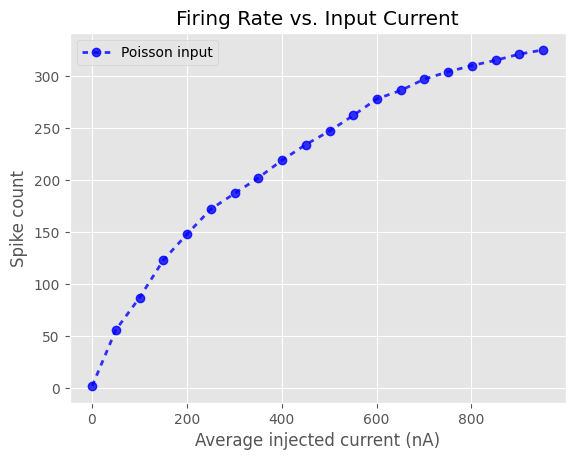

In [224]:
# Plot firing rate vs input current
spk_counts = plot_firing_rate_vs_input(params, rate_range)

Note: F-I curve smoothens out if we increase firing rate.

## Interspike interval distribution

In [207]:
spike_intervals = np.diff(spk_counts) # calculating interspike intervals by subtracting consecutive spikes
duration = params['T']
dt = params['dt']

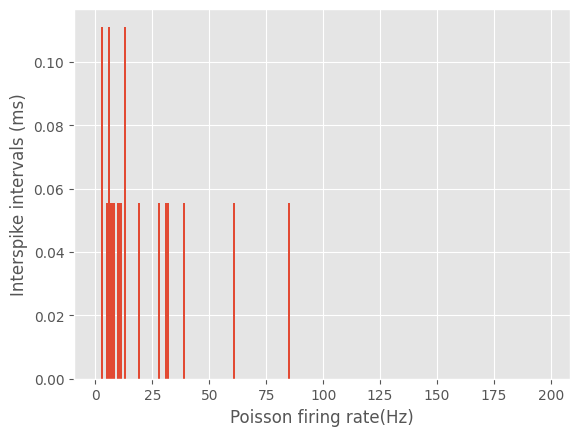

In [240]:
# Compute histogram of the spike intervals
fig, ax = plt.subplots()
bins = 100
binSize = 1 # 1ms bins
x = np.arange(1, 200, binSize)
intervals_dist, bins = np.histogram(spike_intervals[spike_intervals<200], bins=x)
intervals_dist = intervals_dist / (np.sum(intervals_dist) * binSize) # normalize
ax.bar(bins[:-1], intervals_dist, width=binSize)
ax.set_xlabel('Poisson firing rate(Hz)')
ax.set_ylabel('Interspike intervals (ms)')
plt.savefig('ISI_distribution_plot.pdf')

The histogram of the interspike intervals resemblems an exponential probability distribution.

In [225]:
def isi_cv_LIF(spike_times):
  """
  Calculates the inter-spike intervals (isi) and
  the coefficient of variation (cv) for a given spike_train
  Args:
    spike_times : (n, ) vector with the spike times (ndarray)
  Returns:
    isi         : (n-1,) vector with the inter-spike intervals (ms)
    cv          : coefficient of variation of isi (float)
  """
  if len(spike_times) >= 2:
    # Compute isi
    isi = np.diff(spike_times)
    # Compute cv
    cv = np.std(isi)/np.mean(isi)  
  else:
    isi = np.nan
    cv = np.nan
  
  return isi, cv

In [227]:
cv_list = []
# Calculating coefficient of variance in interspike intervals
for rate in rate_range:
    I_pos = generate_poisson_spikes(params, rate)
    rec_spikes = run_synaptic_LIF(params, I_pos)
    _, cv = isi_cv_LIF(rec_spikes)
    cv_list.append(cv)

/var/folders/x2/w3k0335j38d_xs4_cjy_0lzh0000gn/T/ipykernel_15547/724215854.py:15: RuntimeWarning: invalid value encountered in scalar divide
  cv = np.std(isi)/np.mean(isi)


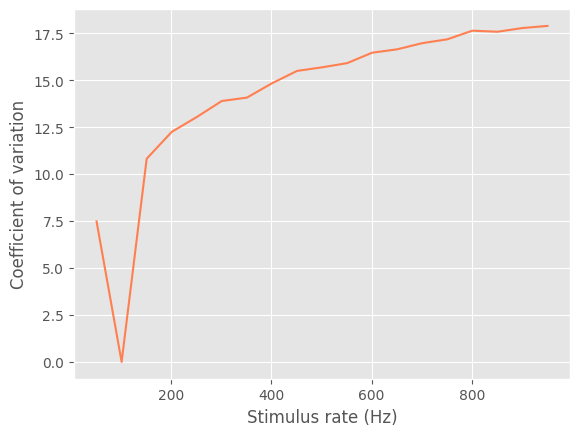

In [238]:
plt.plot(rate_range, cv_list, 'coral')
plt.xlabel('Stimulus rate (Hz)')
plt.ylabel('Coefficient of variation')
plt.savefig('CV_plot.pdf')
plt.show()